In [42]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [43]:
TS = pd.read_excel("./Project 2_2022.xlsx", sheet_name="Data")
TS.Date = TS.Date.apply(pd.Timestamp)
TS = TS.set_index("Date")

In [44]:
TS

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.672202,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721
...,...,...,...
2021-03-27,0.000000,0.000000,0.000000
2021-03-28,0.000000,0.000000,0.000000
2021-03-29,2.356883,3.370738,-1.017679


## Anomalies

Описание этого говна через квантильный коридор

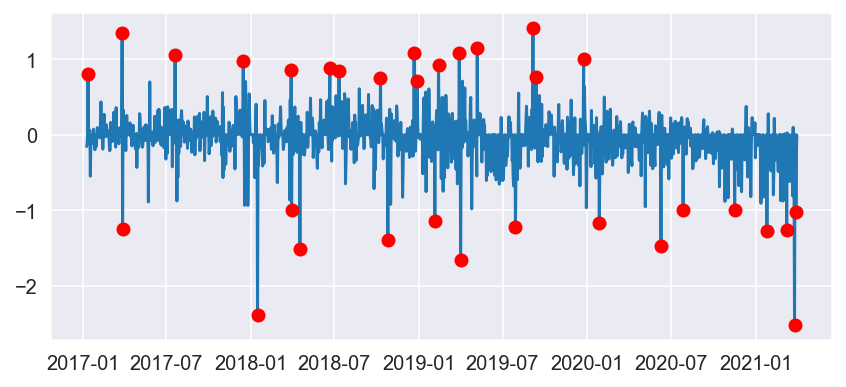

In [45]:
from modules.anomaly import detect_anomalies

anomaly_indexes = detect_anomalies(TS.Balance, visualize=True)

## Feature generation

In [46]:
from tsfresh import extract_relevant_features

timeseries = TS[["Balance"]].reset_index()
extracted_features = extract_relevant_features(timeseries, TS.Balance, column_id="Date", column_sort="Date")

Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


In [47]:
extracted_features

,Balance__sum_values,Balance__range_count__max_1000000000000.0__min_0,Balance__range_count__max_0__min_-1000000000000.0,Balance__value_count__value_0,"Balance__fft_coefficient__attr_""angle""__coeff_0","Balance__fft_coefficient__attr_""real""__coeff_0","Balance__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Balance__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Balance__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Balance__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",...,Balance__mean,Balance__median,Balance__quantile__q_0.6,Balance__absolute_maximum,"Balance__fft_coefficient__attr_""abs""__coeff_0",Balance__root_mean_square,Balance__abs_energy,Balance__count_below__t_0,Balance__range_count__max_1__min_-1,Balance__benford_correlation
2017-01-09,-0.155904,0.0,1.0,0.0,180.0,-0.155904,-0.030236,-0.042760,-0.060472,-0.095614,...,-0.155904,-0.155904,-0.155904,0.155904,0.155904,0.155904,0.024306,1.0,1.0,0.864123
2017-01-10,-0.125572,0.0,1.0,0.0,180.0,-0.125572,-0.024353,-0.034441,-0.048707,-0.077012,...,-0.125572,-0.125572,-0.125572,0.125572,0.125572,0.125572,0.015768,1.0,1.0,0.864123
2017-01-11,0.007767,1.0,0.0,0.0,0.0,0.007767,0.001506,0.002130,0.003013,0.004763,...,0.007767,0.007767,0.007767,0.007767,0.007767,0.007767,0.000060,0.0,1.0,-0.241690
2017-01-12,0.800391,1.0,0.0,0.0,0.0,0.800391,0.155228,0.219525,0.310455,0.490873,...,0.800391,0.800391,0.800391,0.800391,0.800391,0.800391,0.640625,0.0,1.0,-0.272809
2017-01-13,-0.019721,0.0,1.0,0.0,180.0,-0.019721,-0.003825,-0.005409,-0.007649,-0.012095,...,-0.019721,-0.019721,-0.019721,0.019721,0.019721,0.019721,0.000389,1.0,1.0,0.864123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,1.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.295657
2021-03-28,0.000000,1.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.295657
2021-03-29,-1.017679,0.0,1.0,0.0,180.0,-1.017679,-0.197369,-0.279121,-0.394737,-0.624134,...,-1.017679,-1.017679,-1.017679,1.017679,1.017679,1.017679,1.035672,1.0,0.0,0.864123
2021-03-30,-0.259687,0.0,1.0,0.0,180.0,-0.259687,-0.050364,-0.071225,-0.100727,-0.159264,...,-0.259687,-0.259687,-0.259687,0.259687,0.259687,0.259687,0.067437,1.0,1.0,0.295657


## Feature selection

In [111]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

selector = SelectFromModel(estimator=Lasso(alpha=2)).fit(extracted_features, TS.Balance)

In [112]:
selector = SelectFromModel(estimator=RandomForestRegressor(n_estimators=100)).fit(extracted_features, TS.Balance)

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

selector = RFECV(RandomForestRegressor(n_estimators=100), step=1, cv=5).fit(extracted_features, TS.Balance)

KeyboardInterrupt: 

In [120]:
selector.get_support()

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])